In [1]:
#load libraries
import numpy as np
import math
from math import sqrt
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean
from scipy.stats import norm, lognorm
import seaborn as sns
sns.set()
sns.set_style('white')
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance, Voronoi, voronoi_plot_2d, ConvexHull, Delaunay
from collections import defaultdict
import itertools
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import sys
from itertools import combinations 
import time

In [105]:
#load data - eulers, coords, grain IDs, edges
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8,9))

In [3]:
a=sqrt(0.75)

#12 hexagonal close-packed crystal symmetry operators
op25=np.array([[1, 0, 0],[0, 1, 0],[0, 0, 1]])
op26=np.array([[-0.5, a, 0],[-a, -0.5, 0],[0, 0, 1]])
op27=np.array([[-0.5, -a, 0],[a, -0.5, 0],[0, 0, 1]])
op28=np.array([[0.5, a, 0],[-a, 0.5, 0],[0, 0, 1]])
op29=np.array([[-1, 0, 0],[0, -1, 0],[0, 0, 1]])
op30=np.array([[0.5, -a, 0],[a, 0.5, 0],[0, 0, 1]])
op31=np.array([[-0.5, -a, 0],[-a, 0.5, 0],[0, 0, -1]])
op32=np.array([[1, 0, 0],[0, -1, 0],[0, 0, -1]])
op33=np.array([[-0.5, a, 0],[a, 0.5, 0],[0, 0, -1]])
op34=np.array([[0.5, a, 0],[a, -0.5, 0],[0, 0, -1]])
op35=np.array([[-1, 0, 0],[0, 1, 0],[0, 0, -1]])
op36=np.array([[0.5, -a, 0],[-a, -0.5, 0],[0, 0, -1]])

#list of hexagonal sym ops
hex_sym_ops=[op25,op26,op27,op28,op29,op30,op31,op32,op33,op34,op35,op36]

In [4]:
#input is an array in radians as follows euler=[angle_one,angle_two,angle_three]
def misorientation(euler_one, euler_two,sym_op):
    #orientation matrices
    g_one=np.array([[((math.cos(euler_one[0]))*(math.cos(euler_one[2]))-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[0]))*(math.cos(euler_one[2]))+(math.cos(euler_one[0]))*(math.sin(euler_one[2]))*(math.cos(euler_one[1]))),((math.sin(euler_one[2]))*(math.sin(euler_one[1])))],
                [(-(math.cos(euler_one[0]))*(math.sin(euler_one[2]))-(math.sin(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),(-(math.sin(euler_one[0]))*(math.sin(euler_one[2]))+(math.cos(euler_one[0]))*(math.cos(euler_one[2]))*(math.cos(euler_one[1]))),((math.cos(euler_one[2]))*(math.sin(euler_one[1])))],
                [((math.sin(euler_one[0]))*(math.sin(euler_one[1]))),(-(math.cos(euler_one[0]))*(math.sin(euler_one[1]))),(math.cos(euler_one[1]))]        
                ])
   
    #euler_two
    g_two=np.array([[((math.cos(euler_two[0]))*(math.cos(euler_two[2]))-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[0]))*(math.cos(euler_two[2]))+(math.cos(euler_two[0]))*(math.sin(euler_two[2]))*(math.cos(euler_two[1]))),((math.sin(euler_two[2]))*(math.sin(euler_two[1])))],
                [(-(math.cos(euler_two[0]))*(math.sin(euler_two[2]))-(math.sin(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),(-(math.sin(euler_two[0]))*(math.sin(euler_two[2]))+(math.cos(euler_two[0]))*(math.cos(euler_two[2]))*(math.cos(euler_two[1]))),((math.cos(euler_two[2]))*(math.sin(euler_two[1])))],
                [((math.sin(euler_two[0]))*(math.sin(euler_two[1]))),(-(math.cos(euler_two[0]))*(math.sin(euler_two[1]))),(math.cos(euler_two[1]))]        
                ])
    
    #misorientation matrix
    delta_g=np.matmul(g_one,np.linalg.inv(g_two))
    
    #formula from powerpoint
    delta_gd=np.matmul(sym_op,delta_g)
    
    #misorientation angle
    try:
        theta=np.arccos((np.trace(delta_gd)-1)/2)
    #error handling for rounding errors outside of domain
    except:
        if (((np.trace(delta_gd)-1)/2)>1):
            theta=0
        else:
            theta=180

    return math.degrees(theta)

In [5]:
#find the minimum misorientation using sym ops
def disorientation(euler_one, euler_two,sym_ops):
    misorientation_list=[]
    for sym_op in sym_ops:
        misorientation_list.append(misorientation(euler_one, euler_two,sym_op))
        
    return min(misorientation_list)

In [6]:
#creates dictionary of indices and neighboring indices
def adj_dict(data):
    coords=data[:,[3,4]]
    tri=Delaunay(coords)
    neigh=defaultdict(set)
    for p in tri.simplices:
        for i,j in itertools.combinations(p,2):
            neigh[i].add(j)
            neigh[j].add(i)
    return neigh

In [7]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in xrange(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [8]:
def plot(array,mark):
    sns.scatterplot(x=array[:,3],y=array[:,4],marker=mark,hue=array[:,5],palette=new_cmap)

In [9]:
new_cmap = rand_cmap(100, type='bright', first_color_black=False, last_color_black=False, verbose=False)

In [10]:
sys.setrecursionlimit(1000000) 

In [11]:
def rec_vor(row_ID,grain_ID,data_sample,angle):
    #assign angle
    euler_one=[data_sample[row_ID,0],data_sample[row_ID,1],data_sample[row_ID,2]]
    #sample each surrounding point
    for row_ID_2 in vor_adj[row_ID]:
        #make sure grain grows outwards, 'memoization'
        if data_sample[row_ID_2,5]==0:
            #assign second angle
            euler_two=[data_sample[row_ID_2,0],data_sample[row_ID_2,1],data_sample[row_ID_2,2]]
            #if they have a similar orientation, add to the grain, recursivly search
#             if (misorientation(euler_one,euler_two) <= angle):
            if (disorientation(euler_one, euler_two,hex_sym_ops) <= angle):
                # prevent infinite flip-flop recursion
                if data_sample[row_ID_2,5] != grain_ID:
                    data_sample[row_ID_2,5]=grain_ID
                    rec_vor(row_ID_2,grain_ID,data_sample,angle)

In [12]:
#label the grains in an array
def rec_grains(data_sample,angle=15):
    #assign first grain ID
    grain_ID=1
    #set all grains to 0
    data_sample[:,5]=0
    #loop until 
    while True:
        #ID is 0 if unassigned
        unassigned=np.where(data_sample[:,5]==0) 
        #if all grains are assigned
        if len(unassigned[0])==0:
            #returned the labeled array and plot a graph
#             sns.scatterplot(x=data_sample[:,3],y=data_sample[:,4],marker='+',hue=data_sample[:,5],palette=new_cmap)
            return data_sample
        #find first
        row_ID=unassigned[0][0]
        data_sample[row_ID,5]=1
        rec_vor(row_ID,grain_ID,data_sample,angle)
        grain_ID+=1                    

In [15]:
#create adjacency dict
vor_adj=adj_dict(raw_data)

In [16]:
#algorithm generated
labeled_raw_data=rec_grains(raw_data)

C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


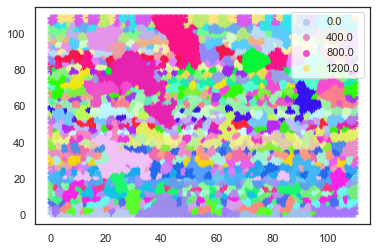

In [104]:
#actual image
plot(raw_data,'+')

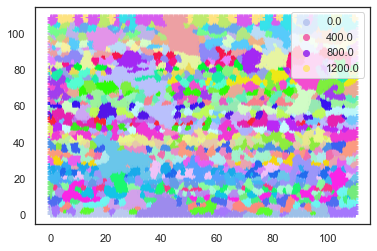

In [103]:
#algorithm
plot(labeled_raw_data,'+')

In [19]:
#slice raw data
coords=labeled_raw_data[:,(3,4)]
grain_IDs=labeled_raw_data[:,5]
print(len(grain_IDs))
grain_IDs_and_edges=labeled_raw_data[:,(5,6)]
coords_and_grains=labeled_raw_data[:,(3,4,5)]
coords_and_grains_copy=np.copy(coords_and_grains)

87017


In [20]:
uniquegrains=np.unique(labeled_raw_data[:,5],return_counts=True)
IDs, count = uniquegrains

In [21]:
#go through IDs to see if they have an edge pixel
for ID in IDs:
    #all rows with the ID
    ID_rows=grain_IDs_and_edges[np.where(grain_IDs_and_edges[:,0] == ID)]
    #search for one in edge column
    for row in ID_rows:
        #if it's an edge
        if row[1]==1:
            #double count in the same index as the edge ID
            ind=np.where(IDs == ID)
            count[int(ind[0])]*=2
            #only double once
            break
        else:
            continue

Text(0, 0.5, 'Frequency')

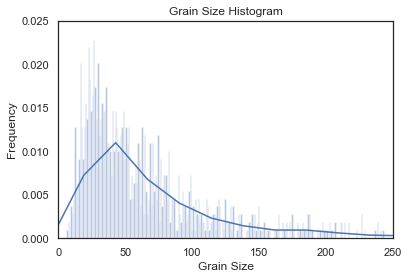

In [22]:
#if density doesn't work, just normalize by sum, bin size determined by 
p_hist, p_bin_edges = np.histogram(count, bins=np.arange(249), density=True)
p_hist = np.append(p_hist, 0)
p=p_hist
p[p==0]=[0.0000000000001]
#p_hist = np.append(p_hist, 0)
# #probability vector
# print(p_hist)
# #grain IDs
# print(p_bin_edges)
sns.distplot(count, p_bin_edges) 
plt.xlim(0, 250)
plt.ylim(0, 0.025)
plt.title("Grain Size Histogram")
plt.xlabel('Grain Size')
plt.ylabel('Frequency')

# plt.hist(count, bins=np.arange(249), range=(0,250), density=True)

In [23]:
#get area of each voronoi region
def voronoi_volumes(points):
    #create voronoi diagram
    v = Voronoi(points)
    #create zeros of len points
    vol = np.zeros(v.npoints)
    #create vol index and get index of voronoi region for input point 
    for i, reg_num in enumerate(v.point_region):
        #get indices of each region
        indices = v.regions[reg_num]
        #-1 means vertex outside diagram
        if -1 in indices: # some regions can be opened
            #maybe instead of inf, ignore?
            #vol[i] = np.inf
            vol[i] = 0
        else:
            #can compute area, use convex hull
            vol[i] = ConvexHull(v.vertices[indices]).volume
    #can use grain IDs, since areas match input point
    return vol

In [24]:
def random_vor(sample,binsize=249):
    #choose random points
    random_coords_and_grains=coords_and_grains[np.random.choice(coords_and_grains.shape[0], sample, replace=False), :]
    random_coords=random_coords_and_grains[:,0:2]
    random_grain_IDs=random_coords_and_grains[:,2]
    
    #get areas
    vol=voronoi_volumes(random_coords)   
    #turn area into percent of total area
    norm_vol=(vol)/sum(vol)
    #multiply by total number of pixels to find how many pixels in each area
    scale_vol=norm_vol*87017
    #round to nearest whole number
    round_vol=np.round(scale_vol,decimals=0)
    #create array, col1 is ID, col2 is area
    grain_IDs_and_areas=np.stack((random_grain_IDs,round_vol),axis=1)
    #get unique IDs and their count
    unique_IDs,unique_IDs_count=np.unique(grain_IDs_and_areas[:,0],return_counts=True)
    #create array to hold unique IDs and their sizes added together
    unique_grain_IDs_and_total_areas=np.stack((unique_IDs,np.zeros(len(unique_IDs))),axis=1)
    
    #construct IDs and count
    for row in unique_grain_IDs_and_total_areas:
        grain=grain_IDs_and_areas[np.where(grain_IDs_and_areas[:,0] == row[0])]
        total=np.sum(grain[:,1])
        row[1]=total
    
    #return count for hist
    count = unique_grain_IDs_and_total_areas[:,1]
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [106]:
def new_p(binsize):
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(249), range=(0,250), density=True)

    uniquegrains=np.unique(raw_data[:,5],return_counts=True)
    IDs, count = uniquegrains
    
    p_hist, p_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    p_hist = np.append(p_hist, 0)
    p_hist[p_hist==0]=[0.0000000000001]
    p=p_hist
    return p

In [116]:
def grain_rect_count(percent,binsize=249):
    percent=percent/100
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*percent))) and (coords_and_grains_copy[index,1]<int((110*percent))):
            row_list.append(coords_and_grains_copy[index])
        else:
            continue

    row_tuple=tuple(row_list)
    coords_and_grains_slice=np.vstack(row_tuple)
    grains_slice=coords_and_grains_slice[:,2]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains
    
#     #create array to hold grain IDs and edge column
#     edges=np.zeros((len(coords_and_grains_slice),1))
#     coords_and_grain_slice_with_edges=np.concatenate((coords_and_grains_slice,edges.reshape(-1,1)),axis=1)
    
#     #min x
#     left_edge=np.amin(coords_and_grains_slice[:,0])
#     #max x
#     right_edge=np.amax(coords_and_grains_slice[:,0])
#     #min y
#     bottom_edge=np.amin(coords_and_grains_slice[:,1])
#     #max y
#     top_edge=np.amax(coords_and_grains_slice[:,1])
#     #assign edge grains
#     for row in coords_and_grain_slice_with_edges:
#         #x values
#         if row[0] <= left_edge or row[0] >= right_edge:
#             #it's an edge
#             row[3]=1
#         #y values
#         if row[1] <= bottom_edge or row[1] >= top_edge:
#             #it's an edge
#             row[3]=1
            
#     #plot showing edges
# #     sns.scatterplot(x=coords_and_grain_slice_with_edges[:,0],y=coords_and_grain_slice_with_edges[:,1],marker='o',hue=coords_and_grain_slice_with_edges[:,3])
            
#     #slice array for edge calculation
#     grain_slice_and_edges=coords_and_grain_slice_with_edges[:,2:4]
    
#     #double window edge grains
#     for ID in IDs:
#     #all rows with the ID
#         ID_rows=grain_slice_and_edges[np.where(grain_slice_and_edges[:,0] == ID)]
#         #search for one in edge column
#         for row in ID_rows:
#             #if it's an edge
#             if row[1]==1:
#                 #double count in the same index as the edge ID
#                 ind=np.where(IDs == ID)
#                 count[int(ind[0])]*=2
#                 #only double once
#                 break
#             else:
#                 continue
    
#     plt.xlim(0,250)
#     plt.hist(count, bins=np.arange(binsize), range=(0,250), density=True)
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q
#     return count, q_bin_edges
#     return q,q_bin_edges

In [27]:
def random(sample,binsize=249):
    #random_count = np.random.choice(count, sample, replace=False)
    random_grain_IDs=np.random.choice(grain_IDs,sample, replace=False)
    random_unique_grains=np.unique(random_grain_IDs,return_counts=True)
    random_ID, random_count = random_unique_grains
    scale=(int(len(grain_IDs)))/(sample)
    scaled_random_count=scale*random_count
    #return scaled_random_count
    q_hist, q_bin_edges = np.histogram(scaled_random_count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q
    #return scaled_random_count, q_bin_edges

In [28]:
def grid(res,start=0,binsize=249):
    grid_grain_IDs=grain_IDs[start::res]
    grid_unique_grains=np.unique(grid_grain_IDs,return_counts=True)
    grid_ID, grid_count = grid_unique_grains
    scale=(int(len(grain_IDs)))/(int(len(grid_grain_IDs)))
    scaled_grid_count=scale*grid_count
    
#     plt.xlim(0,250)
#     plt.hist(scaled_grid_count, bins=np.arange(binsize), range=(0,250), density=True, rwidth=10)
    
    q_hist, q_bin_edges = np.histogram(scaled_grid_count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q

In [29]:
def fine_grid(res,binsize=249):
    grid_grain_IDs=np.delete(grain_IDs, np.arange(0, grain_IDs.size, res))
    grid_unique_grains=np.unique(grid_grain_IDs,return_counts=True)
    grid_ID, grid_count = grid_unique_grains
    scale=(int(len(grain_IDs)))/(int(len(grid_grain_IDs)))
    scaled_grid_count=scale*grid_count
    
#     plt.xlim(0,250)
#     plt.hist(scaled_grid_count, bins=np.arange(binsize), range=(0,250), density=True, rwidth=10)
    
    q_hist, q_bin_edges = np.histogram(scaled_grid_count, bins=np.arange(binsize), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    return q 

In [30]:
def kl_divergence(p, q, binsize=249):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(binsize))

def js_divergence(p, q, binsize=249):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m, binsize) + 0.5 * kl_divergence(q, m, binsize)

In [31]:
def js_divergence_scipy(hist1,hist2):
    #square distance to find divergence, use log2
    return (distance.jensenshannon(hist1, hist2, base=2))**2

In [154]:
#x axis as percent

random_percent=[]
for i in range (1,87000,100):
    random_percent.append((i/87000)*100)
    
grid_percent=[]
for i in range(1,50,1):
    grid_percent.append(((87017/i)/87017)*100)
    
fine_grid_percent=[]
for i in range(2,100,1):
    fine_grid_percent.append(((87017-(87017/i))/87017)*100)
    
window_percent=[]
for i in range(2,100,1):
    window_percent.append(i)

In [122]:
((87017/2)/87017)*100

50.0

In [107]:
#using scipy calculation

random_divergence_scipy=[]
for i in range (1,87000,100):
    random_divergence_scipy.append(js_divergence_scipy(new_p(249), random(i)))

grid_divergence_scipy=[]
for i in range(1,50,1):
    grid_divergence_scipy.append(js_divergence_scipy(new_p(249),grid(i)))
    
fine_grid_divergence_scipy=[]
for i in range(2,100,1):
    fine_grid_divergence_scipy.append(js_divergence_scipy(new_p(249), fine_grid(i)))

In [117]:
window_divergence_scipy=[]
for i in range(2,100,1):
    window_divergence_scipy.append(js_divergence_scipy(new_p(249), grain_rect_count(sqrt(i*100))))

In [108]:
# vor_percent=[]
# for i in range (100,87000,100):
#     random_percent.append((i/87000)*100)
    
# vor_divergence_scipy=[]
# for i in range (100,87000,100):
#     random_divergence_scipy.append(js_divergence_scipy(new_p(249), random_vor(i)))

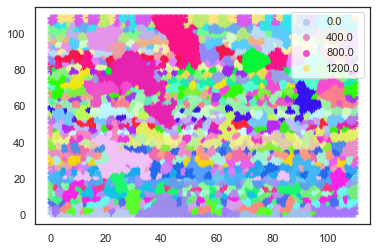

In [120]:
#actual image
plot(raw_data,'+')

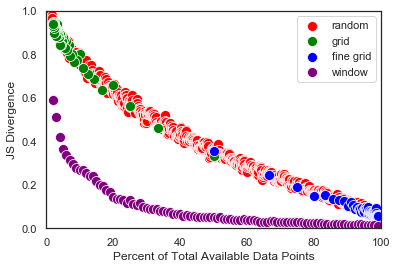

In [118]:
plt.xlim(0, 100)
plt.ylim(0, 1)
# plt.title('JS Divergence of Labeling Algorithm and Actual Image')
plt.xlabel('Percent of Total Available Data Points')
plt.ylabel('JS Divergence')

#SciPy, log2
#random
sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="red", marker="o", label='random')
#grid
sns.scatterplot(grid_percent, grid_divergence_scipy, s=100, color="green", marker="o", label='grid')
#fine grid
sns.scatterplot(fine_grid_percent, fine_grid_divergence_scipy, s=100, color="blue", marker="o", label='fine grid')
#window
sns.scatterplot(window_percent, window_divergence_scipy, s=100, color="purple", marker="o", label='window')

In [52]:
#rewrite to support two arrays?, voronoi, grid-based, check to see if grid arrays are identical

In [44]:
#load data - eulers, coords, grain IDs, edges
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8,9))

In [112]:
#one array to hold all percents
sparse_random_percent=[]
for k in range(5,105,5):
    sparse_random_percent.append(k)
print(sparse_random_percent)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [113]:
sparse_random=[]

for k in range(5,105,5):
    print(k)
    #convert percent to sample size
    sam=int(87017*(k/100))
    print(sam)
    #randomly sample raw data
    raw_data_sample=raw_data[np.random.choice(raw_data.shape[0], sam, replace=False), :]
    #create adjacency dict
    vor_adj=adj_dict(raw_data_sample)
    #label array with algorithm
    labeled_raw_data=rec_grains(raw_data_sample)

    random_unique_grains=np.unique(labeled_raw_data[:,5],return_counts=True)
    random_ID, random_count = random_unique_grains
    scale=(int(len(labeled_raw_data[:,5])))/(sam)
    scaled_random_count=scale*random_count
    
    q_hist, q_bin_edges = np.histogram(scaled_random_count, bins=np.arange(249), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    sparse_random.append(js_divergence_scipy(new_p(249), q))

5
4350


C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


10
8701
15
13052
20
17403
25
21754
30
26105
35
30455
40
34806
45
39157
50
43508
55
47859
60
52210
65
56561
70
60911
75
65262
80
69613
85
73964
90
78315
95
82666
100
87017


In [ ]:
#would expect sparse to perform worse, or at least identically if algorithm was perfect, also divergence of 0 at 100%

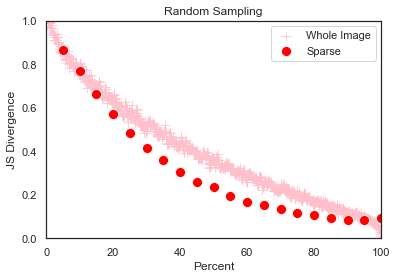

In [126]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Random Sampling')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')

#random
sns.scatterplot(random_percent, random_divergence_scipy, s=100, color="pink", marker="+", label='Whole Image')
#sparse random
sns.scatterplot(sparse_random_percent, sparse_random, s=100, color="red", marker="o", label='Sparse')

In [166]:
#load data - eulers, coords, grain IDs, edges
raw_data = np.loadtxt('Raw Data/AZ31B Ecomp 10e0 Int_3 raw1.txt', skiprows=17, usecols=(0,1,2,3,4,8,9))

In [97]:
#one array to hold all percents
sparse_window_percent=[]
for k in range(5,105,5):
# for k in range(10,110,10):
    sparse_window_percent.append(k)
print(sparse_window_percent)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [98]:
sparse_window=[]

for k in range(5,105,5):
# for k in range(10,110,10):
    print(k)
    #convert percent window input
    k=sqrt(k*100)  
    k=k/100
    
    coords=raw_data[:,(3,4)]
    grain_IDs=raw_data[:,5]
    grain_IDs_and_edges=raw_data[:,(5,6)]
    coords_and_grains=raw_data[:,(3,4,5)]
    coords_and_grains_copy=np.copy(coords_and_grains)
    
    row_list=[]
    for index in range(0,len(coords_and_grains)):
        if (coords_and_grains_copy[index,0]<int((110*k))) and (coords_and_grains_copy[index,1]<int((110*k))):
            row_list.append(raw_data[index])
        else:
            continue
    
    row_tuple=tuple(row_list)
    raw_data_slice=np.vstack(row_tuple)
    
    #create adjacency dict
    vor_adj=adj_dict(raw_data_slice)
    #label array with algorithm
    labeled_raw_data=rec_grains(raw_data_slice) 
    
    grains_slice=raw_data_slice[:,5]
    uniquegrains=np.unique(grains_slice,return_counts=True)
    IDs, count = uniquegrains   
    
    q_hist, q_bin_edges = np.histogram(count, bins=np.arange(249), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    sparse_window.append(js_divergence_scipy(new_p(249), q))

5


C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


In [99]:
print(len(sparse_window_percent))
print(len(sparse_window))

20
20


In [ ]:
#would expect to behave identically

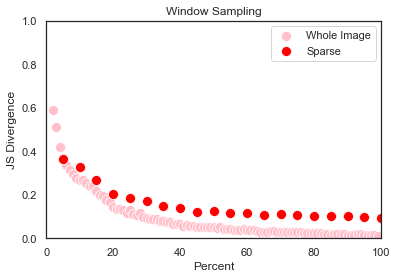

In [176]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Window Sampling')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')

#window
sns.scatterplot(window_percent, window_divergence_scipy, s=100, color="pink", marker="o", label='Whole Image')
#sparse window
sns.scatterplot(sparse_window_percent, sparse_window, s=100, color="red", marker="o", label='Sparse')

In [ ]:
#is window the best solution to the sparse problem, since there is no need for reconstruction?

In [121]:
#is interpolation 'slerp' relevant since angle is discrete?
#in the algorithms, is fixed scaling messing up the results?
#if discrete, is a simple voronoi the best guess and interpolation method?
#are the paper's sampling methods more appropriate for the diffraction pattern image?

In [164]:
sparse_grid_percent=[]
for k in range(1,50,5):
# for k in range(10,60,10):
    sparse_grid_percent.append(((87017/k)/87017)*100)

In [163]:
sparse_fine_grid_percent=[]
for k in range(10,110,10):
    sparse_fine_grid_percent.append(((87017-(87017/k))/87017)*100)

In [165]:
print(sparse_fine_grid_percent)

[90.0, 95.0, 96.66666666666667, 97.5, 98.00000000000001, 98.33333333333333, 98.57142857142857, 98.75, 98.88888888888889, 99.0]


In [145]:
sparse_grid=[]

for k in range(1,50,5):
# for k in range(10,60,10):
    print(k)
    #grid sample raw data
    raw_data_sample=raw_data[::k]
    #create adjacency dict
    vor_adj=adj_dict(raw_data_sample)
    #label array with algorithm
    labeled_raw_data=rec_grains(raw_data_sample)
    
    grid_unique_grains=np.unique(labeled_raw_data[:,5],return_counts=True)
    grid_ID, grid_count = grid_unique_grains
    scale=(int(len(grain_IDs)))/(int(len(labeled_raw_data)))
    scaled_grid_count=scale*grid_count
    
    q_hist, q_bin_edges = np.histogram(scaled_grid_count, bins=np.arange(249), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    sparse_grid.append(js_divergence_scipy(new_p(249), q))

1


C:\Users\GREEN\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


6
11
16
21
26
31
36
41
46


In [174]:
print(len(raw_data))

87017


In [177]:
sparse_fine_grid=[]

for k in range(10,110,10):
# for k in range(10,60,10):
    print(k)
    #grid sample raw data
    grain_IDs=
    raw_data_sample=np.delete(raw_data[:,5], np.arange(0, 87017, k))
    print(len(raw_data_sample))
    #create adjacency dict
    vor_adj=adj_dict(raw_data_sample)
    #label array with algorithm
    labeled_raw_data=rec_grains(raw_data_sample)
    
    grid_unique_grains=np.unique(labeled_raw_data[:,5],return_counts=True)
    grid_ID, grid_count = grid_unique_grains
    scale=(int(len(grain_IDs)))/(int(len(labeled_raw_data)))
    scaled_grid_count=scale*grid_count
    
    q_hist, q_bin_edges = np.histogram(scaled_grid_count, bins=np.arange(249), range=(0,250), density=True)
    q_hist = np.append(q_hist, 0)
    q=q_hist
    q[q==0]=[0.0000000000001]
    
    sparse_fine_grid.append(js_divergence_scipy(new_p(249), q))

10
78315


IndexError: too many indices for array

In [155]:
print(len(fine_grid_percent))
print(len(fine_grid_divergence_scipy))

98
98


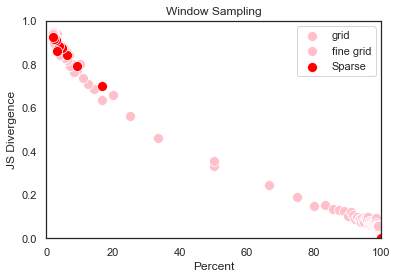

In [156]:
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.title('Window Sampling')
plt.xlabel('Percent')
plt.ylabel('JS Divergence')

#grid
sns.scatterplot(grid_percent, grid_divergence_scipy, s=100, color="pink", marker="o", label='grid')
#fine grid
sns.scatterplot(fine_grid_percent, fine_grid_divergence_scipy, s=100, color="pink", marker="o", label='fine grid')
#sparse window
sns.scatterplot(sparse_grid_percent, sparse_grid, s=100, color="red", marker="o", label='Sparse')

In [ ]:


#